In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.cross_validation import train_test_split

In [13]:
LEARNING_RATE = 1e-4

# iterations for training
TRAINING_ITERATIONS = 2500

# avoid overfitting
DROPOUT = 0.5

BATCH_SIZE = 50

VALIDATION_SIZE = 2000

IMAGE_TO_DISPLAY = 10

In [14]:
data = input_data.read_data_sets('../../MNIST_data', one_hot=True)
#print ("data count:%s" % data.count())
dataset = pd.read_csv('../input/train.csv')
dataset.info()
dataset.head()

Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(42000, 784)
(28, 28)


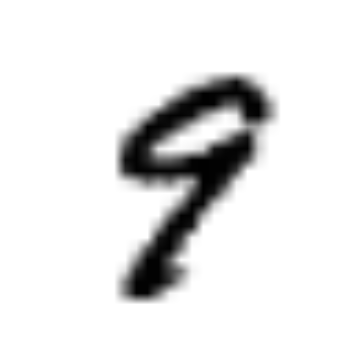

In [15]:
# 1. handle data

images = dataset.iloc[:, 1:].values
images = images.astype(np.float)

images = np.multiply(images, 1.0 / 255.0)

print (images.shape)

image_size = images.shape[1]

image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

print(image_width, image_height)

def Display(img):
    one_image = img.reshape(image_width, image_height)
    
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)

Display(images[IMAGE_TO_DISPLAY + 1])

# 2. handle label

label_flat = dataset[[0]].values.ravel()
labels_count = np.unique(label_flat).shape[0]

## 2.1 one hot encode labels

# def DenseToOneHot(labels):
#     num_labels = labels.shape[0]
#     num_classes = np.unique(label_flat).shape[0]
#     index_offset = np.arange(num_labels) * num_classes

#     labels_one_hot = np.zeros((num_labels, num_classes))
#     labels_one_hot.flat[index_offset + labels.ravel()] = 1
#     return labels_one_hot

# labels = DenseToOneHot(label_flat)
# print labels.shape

# use sklearn to onhotencoder labels

from sklearn.preprocessing import OneHotEncoder

labels_reshape = label_flat.reshape(label_flat.shape[0], 1)

enc = OneHotEncoder().fit_transform(labels_reshape)

labels = enc.toarray()

# 3. split data to train and test data

from sklearn.cross_validation import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, random_state=2016, test_size=.4)

In [16]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

In [17]:
def WeightVariable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def BiasVariabel(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def Conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def MaxPoll2X2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')



# define placeholder for inputs to network
xs = tf.placeholder(tf.float32, [None, 784]) # 28x28
ys = tf.placeholder(tf.float32, [None, 10])
keep_prob = tf.placeholder(tf.float32)
x_image = tf.reshape(xs, [-1, 28, 28, 1])
# print(x_image.shape)  # [n_samples, 28,28,1]

## conv1 layer ##
W_conv1 = WeightVariable([5,5, 1,32]) # patch 5x5, in size 1, out size 32
b_conv1 = BiasVariabel([32])
h_conv1 = tf.nn.relu(Conv2d(x_image, W_conv1) + b_conv1) # output size 28x28x32
h_pool1 = MaxPoll2X2(h_conv1)                                         # output size 14x14x32


W_conv2 = WeightVariable([5, 5, 32, 64])
b_conv2 = BiasVariabel([64])
h_conv2 = tf.nn.relu(Conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = MaxPoll2X2(h_conv2)


W_fc1 = WeightVariable([7*7*64, 1024])
b_fcl = BiasVariabel([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat , W_fc1) + b_fcl)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = WeightVariable([1024, 10])
b_fc2 = BiasVariabel([10])
y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(ys * tf.log(y), reduction_indices=[1]))

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(ys, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))


In [18]:
predict = tf.argmax(y, 1)

In [19]:
# InteractiveSession 与 Session 是不同的
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

#print batch
train_accuracies = []
validation_accuracies = []
train_crosses = []
validation_crosses =[]
steps = []

for step in range(TRAINING_ITERATIONS):
    batch_xs, batch_ys = next_batch(BATCH_SIZE)

    if step % 10 == 0:
        train_accuracy = accuracy.eval(feed_dict={
                                                  xs: batch_xs, 
                                                  ys: batch_ys,
                                                  keep_prob: 1.0})
        train_accuracies.append(train_accuracy)
        
        #np.random.sample(test_images, BATCH_SIZE)
        validation_accuracy = accuracy.eval(feed_dict={
                                                  xs: test_images[0:BATCH_SIZE], 
                                                  ys: test_labels[0:BATCH_SIZE],
                                                  keep_prob: 1.0 })
        validation_accuracies.append(validation_accuracy)
                
        train_cross = cross_entropy.eval(feed_dict={
                                                  xs: batch_xs, 
                                                  ys: batch_ys,
                                                  keep_prob: 1.0})
        train_crosses.append(train_cross)
        
        #np.random.sample(test_images, BATCH_SIZE)
        validation_cross = cross_entropy.eval(feed_dict={
                                                  xs: test_images[0:BATCH_SIZE], 
                                                  ys: test_labels[0:BATCH_SIZE],
                                                  keep_prob: 1.0 })
        validation_crosses.append(validation_cross)
        steps.append(step)
        
        print('(ta %.4f , va %.4f for step %d' % (train_accuracy, validation_accuracy, step))
    sess.run(train_step, feed_dict={xs: batch_xs, ys: batch_ys, keep_prob: 0.5})

(ta 0.0200 , va 0.0800 for step 0
(ta 0.2800 , va 0.1800 for step 10
(ta 0.5200 , va 0.3400 for step 20
(ta 0.4800 , va 0.4600 for step 30
(ta 0.5000 , va 0.4400 for step 40
(ta 0.3800 , va 0.6200 for step 50
(ta 0.7000 , va 0.6000 for step 60
(ta 0.7600 , va 0.6200 for step 70
(ta 0.7200 , va 0.7000 for step 80
(ta 0.7600 , va 0.6800 for step 90
(ta 0.8200 , va 0.7600 for step 100
(ta 0.8400 , va 0.7200 for step 110
(ta 0.8200 , va 0.7800 for step 120
(ta 0.8800 , va 0.8400 for step 130
(ta 0.8400 , va 0.8200 for step 140
(ta 0.8400 , va 0.8200 for step 150
(ta 0.8000 , va 0.9000 for step 160
(ta 0.9000 , va 0.8800 for step 170
(ta 0.8600 , va 0.8800 for step 180
(ta 0.7200 , va 0.9000 for step 190
(ta 0.8600 , va 0.9200 for step 200
(ta 0.9200 , va 0.9000 for step 210
(ta 0.9200 , va 0.9200 for step 220
(ta 0.9200 , va 0.9400 for step 230
(ta 0.9400 , va 0.9400 for step 240
(ta 0.8800 , va 0.9400 for step 250
(ta 0.9800 , va 0.9200 for step 260
(ta 0.9400 , va 0.9400 for step 270
(ta

## Plot accuracy

train_accuracy => 0.0329


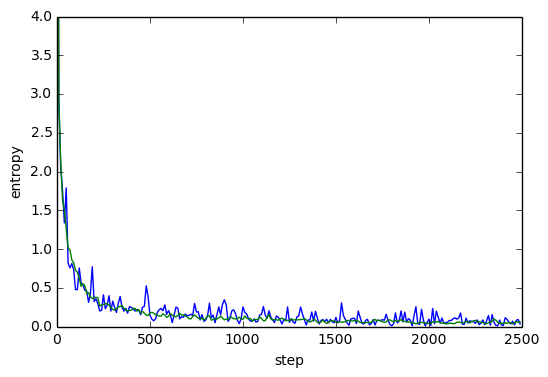

train_accuracy => 1.0000


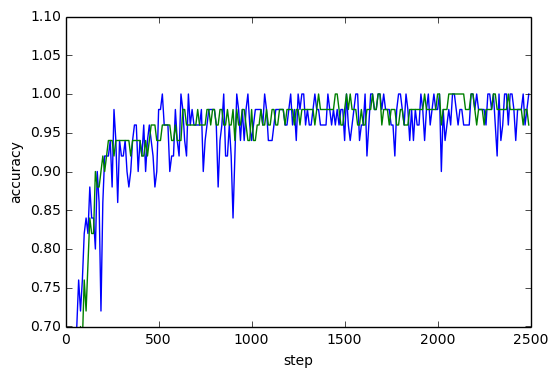

In [23]:
print('train_accuracy => %.4f' % train_cross)
plt.plot(steps, train_crosses, '-b')
plt.plot(steps, validation_crosses, '-g')
plt.ylim(ymax=4)
plt.xlabel("step")
plt.ylabel("entropy")
plt.show()

print('train_accuracy => %.4f' % train_accuracy)
plt.plot(steps, train_accuracies, '-b')
plt.plot(steps, validation_accuracies, '-g')
plt.ylim(ymax=1.1, ymin=.7)
plt.xlabel("step")
plt.ylabel("accuracy")
plt.show()

# predict test

In [21]:
test_images = pd.read_csv('../input/test.csv').values
test_images = test_images.astype(np.float)
test_images = np.multiply(test_images, 1.0 / 255.0)

print('test_images({0[0]},{0[1]})'.format(test_images.shape))

predicted_labels = np.zeros(test_images.shape[0])

for i in range(0, test_images.shape[0]//BATCH_SIZE):
    predicted_labels[i*BATCH_SIZE: (i+1) * BATCH_SIZE] = predict.eval(feed_dict={
                                                                    xs:test_images[i*BATCH_SIZE: (i+1)*BATCH_SIZE],
                                                                    keep_prob: 1.0
                                                                    })
print('predict labels:%s' % len(predicted_labels))
#display(test_images[IMAGE_TO_DISPLAY])
print('predict label => %s' % (predicted_labels[IMAGE_TO_DISPLAY]))
image_id = range(1, len(predicted_labels) + 1)
submission = pd.DataFrame({
            'ImageId':image_id,
            'Label':predicted_labels.astype(np.int)        
})
submission.to_csv('submission.csv', index=False)
print ("Predict finished!")

test_images(28000,784)
predict labels:28000
predict label => 5.0
Predict finished!
